 # An Introduction to Quantum Computation

The aim of this tutorial is to show all of you how simple and straightforward it is to use an actual quantum computer. Maybe somebody will get inspired!

First, let us import some python packages and define useful functions. We will be using an [IBM quantum computer](https://www.ibm.com/quantum-computing/) and communicate with it using both the [IBM qiskit](https://qiskit.org/documentation/install.html) package and the [pennylane](https://pennylane.ai/install.html) package (with [qiskit plugin](https://pennylane-qiskit.readthedocs.io/en/latest/installation.html)) developed by [Xanadu](https://www.xanadu.ai/) in Toronto.

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from qiskit import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

def plot_rho(rho):
    plt.figure()
    plt.subplot(121)
    plt.imshow(np.real(rho), clim=(0,0.5))
    plt.colorbar()
    plt.title(r"Re[$\rho_{exp}$]");
    plt.subplot(122)
    plt.imshow(np.imag(rho), clim=(0,0.5))
    plt.colorbar()
    plt.title(r"Im[$\rho_{exp}$]");


# Quantum circuits

Quantum circuit start with a bunch of qubits all in the state $\ket{0}$ and then apply a bunch of unitary gates. Finally, a measurement in the computational basis (z-basis) is performed.

Here is a list of the most important gates and their implementation in qiskit.

### Pauli-gates

In [79]:
# Create a Quantum Circuit acting on a quantum register of one qubit
qc = QuantumCircuit(1)
# Apply gates
qc.x(0)
qc.y(0)
qc.z(0)
print(qc)

        ┌───┐┌───┐┌───┐
q_0: |0>┤ X ├┤ Y ├┤ Z ├
        └───┘└───┘└───┘


### Hadamard gate

$$
H = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1\\
1 & -1
\end{pmatrix}
,
\quad
H \ket{0} = \ket{+}
,
\quad
H \ket{1} = \ket{-}
,
\quad
H \ket{+} = \ket{0}
,
\quad
H \ket{-} = \ket{1}
$$

In [80]:
qc = QuantumCircuit(1)
qc.h(0)
print(qc)

        ┌───┐
q_0: |0>┤ H ├
        └───┘


### S gate (phase gate)

$$
S = \begin{pmatrix}
1 & 0\\
0 & i
\end{pmatrix}
,
\quad
S \ket{+} = \frac{1}{\sqrt{2}}\left(\ket{0} + i \ket{1}\right) = \ket{\circlearrowright}
,
\quad
S \ket{-} = \frac{1}{\sqrt{2}}\left(\ket{0} - i \ket{1}\right) = \ket{\circlearrowleft}
$$

In [81]:
qc = QuantumCircuit(1)
qc.s(0)
print(qc)

        ┌───┐
q_0: |0>┤ S ├
        └───┘


### Controlled Not (CX, CNOT)

$$
CX\ket{00} = \ket{00}, \quad
CX\ket{01} = \ket{01}, \quad
CX\ket{10} = \ket{11}, \quad
CX\ket{11} = \ket{10}
$$

In [82]:
qc = QuantumCircuit(2)
qc.cx(0,1)
print(qc)

             
q_0: |0>──■──
        ┌─┴─┐
q_1: |0>┤ X ├
        └───┘


### Controlled Z (CZ)

$$
CZ\ket{00} = \ket{00}, \quad
CZ\ket{01} = \ket{01}, \quad
CZ\ket{10} = \ket{10}, \quad
CZ\ket{11} = -\ket{11}
$$

In [78]:
qc = QuantumCircuit(2)
qc.cz(0,1)
print(qc)

           
q_0: |0>─■─
         │ 
q_1: |0>─■─
           


# Bell singlet

One of the simplest nontrivial quantum states is the Bell singlet state
$$|\Psi\rangle = \frac{1}{\sqrt{2}}(|01\rangle - |10\rangle),$$. We implement it with the quantum circuit below.

In [71]:
# Create a Quantum Circuit acting on a quantum register of two qubits
qc = QuantumCircuit(2)
# Apply a bunch of unitary gates
qc.x([0,1])
qc.h(0)
qc.cx(0,1)
qc.measure_all()
print(qc)

             ┌───┐┌───┐      ░ ┌─┐   
     q_0: |0>┤ X ├┤ H ├──■───░─┤M├───
             ├───┤└───┘┌─┴─┐ ░ └╥┘┌─┐
     q_1: |0>┤ X ├─────┤ X ├─░──╫─┤M├
             └───┘     └───┘ ░  ║ └╥┘
measure_0: 0 ═══════════════════╩══╬═
                                   ║ 
measure_1: 0 ══════════════════════╩═
                                     


Does this circuit really do what we want? Let's check, step by step:
$$
\ket{00}\rightarrow \ket{11} \rightarrow \frac{1}{2}\left(\ket{01} - \ket{11} \right) \rightarrow \frac{1}{2}\left(\ket{01} - \ket{10}\right)
$$

Good!  The circuit is followed by two measurements un the computational basis (z-basis) that store the outcomes in the classical bits `measure_0` and `measure_1` shown by double wires.

Now let's connect to the IBM cloud. Access to the quantum computers is free and unlimited for everyone.

In [103]:
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
provider.backends()
simulator_cloud = provider.get_backend('ibmq_qasm_simulator')
simulator = Aer.get_backend('qasm_simulator')

We can choose to first run the quantum circuit on a simulator. The results are as expected: roughly half the timem '01' and half the time '10'.

In [40]:
job_sim = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=1024)
result_sim = job_sim.result()
counts_sim = result_sim.get_counts(qc)
print(counts_sim)

{'10': 510, '01': 514}


Running the circuit on the actual quantum device is just as simple. Note the parameter `shots=1024` that defines how many times the experiment is to be repeated.

In [41]:
least_busy = providers.ibmq.least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 2)[1:])
job_exp = execute(qc, backend=least_busy, shots=1024)
job_monitor(job_exp)

Job Status: job has successfully run


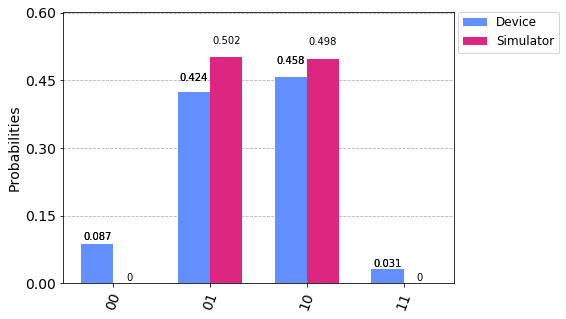

In [42]:
result_exp = job_exp.result()
counts_exp = result_exp.get_counts(qc)
plot_histogram([counts_exp,counts_sim], legend=['Device', 'Simulator'])

## 1. Quantum state tomography

Measurement in the $x$-basis is performed by applying a Hadamard gate followed by $z$-measurement. This is because $\ket{+}=\ket{0}$ and $\ket{-}=\ket{1}$. For a $y$-measurement we apply $S^\dagger H$ before $z$-measurement: $ H S^\dagger \ket{\circlearrowright} = \ket{0}$, $ H S^\dagger \ket{\circlearrowleft} = \ket{1}$.

Our goal is to construct the reduced density matrix from measurements of all possible combinations of $x$-, $y$-, and $z$-measurements (i.e. there are $3^n$ measurements for $n$ qubits). We contruct all 9 circuit corresponding to these measurements below.

In [145]:
qc = QuantumCircuit(2)
qc.x([0,1])
qc.h(0)
qc.cx(0,1)
qc.rx(1.2,0)
qc.ry(0.61,1)
qc.rz(0.53,1)
qc.cz(0,1)
qc_tomo = state_tomography_circuits(qc, qc.qubits)
for i in np.arange(len(qc_tomo)):
    print(qc_tomo[i])

        ┌───┐┌───┐     ┌─────────┐                 ░ ┌───┐┌─┐   
q_0: |0>┤ X ├┤ H ├──■──┤ Rx(1.2) ├──────────────■──░─┤ H ├┤M├───
        ├───┤└───┘┌─┴─┐├─────────┴┐┌──────────┐ │  ░ ├───┤└╥┘┌─┐
q_1: |0>┤ X ├─────┤ X ├┤ Ry(0.61) ├┤ Rz(0.53) ├─■──░─┤ H ├─╫─┤M├
        └───┘     └───┘└──────────┘└──────────┘    ░ └───┘ ║ └╥┘
c4_0: 0 ═══════════════════════════════════════════════════╩══╬═
                                                              ║ 
c4_1: 0 ══════════════════════════════════════════════════════╩═
                                                                
        ┌───┐┌───┐     ┌─────────┐                 ░  ┌───┐ ┌─┐        
q_0: |0>┤ X ├┤ H ├──■──┤ Rx(1.2) ├──────────────■──░──┤ H ├─┤M├────────
        ├───┤└───┘┌─┴─┐├─────────┴┐┌──────────┐ │  ░ ┌┴───┴┐└╥┘┌───┐┌─┐
q_1: |0>┤ X ├─────┤ X ├┤ Ry(0.61) ├┤ Rz(0.53) ├─■──░─┤ Sdg ├─╫─┤ H ├┤M├
        └───┘     └───┘└──────────┘└──────────┘    ░ └─────┘ ║ └───┘└╥┘
c4_0: 0 ═══════════════════════════════════════════════

In [146]:
#least_busy = providers.ibmq.least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 2)[1:])
job_exp = execute(qc_tomo, backend=simulator, shots=1000000)
job_monitor(job_exp)
tomo = StateTomographyFitter(job_exp.result(), qc_tomo)
rho = tomo.fit()

Job Status: job has successfully run


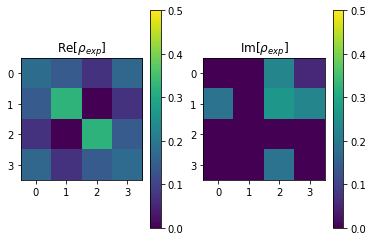

In [147]:
plot_rho(rho)

In [148]:
x = np.array([[0,1],[1,0]],dtype=complex)
y = np.array([[0,-1j],[1j,0]],dtype=complex)
z = np.array([[1,0],[0,-1]],dtype=complex)
e = np.array([[1,0],[0,1]],dtype=complex)
p = np.array([x,y,z])

def ret(dictionary, key):
    if key in dictionary:
        return dictionary[key]
    else:
        return 0

pl = np.zeros((2,3))
mi = np.zeros((2,3))

r = np.eye(4,dtype=complex)
for i1 in np.arange(3):
    for i2 in np.arange(3):
        c = job_exp.result().get_counts(int(3*i1+i2))
        plus = ret(c,'00')+ret(c,'11')
        minus = ret(c,'01')+ret(c,'10')
        r += (plus - minus) / (plus + minus) * np.kron(p[i2],p[i1])
        
        for k in np.arange(3):
            if i1 == k:
                pl[0,k] += ret(c,'00')+ret(c,'10')
                mi[0,k] += ret(c,'01')+ret(c,'11')
            if i2 == k:
                pl[1,k] += ret(c,'00')+ret(c,'01')
                mi[1,k] += ret(c,'11')+ret(c,'10')
                
for k in np.arange(3):
    r += (pl[0,k] - mi[0,k]) / (pl[0,k] + mi[0,k]) * np.kron(e, p[k])
    r += (pl[1,k] - mi[1,k]) / (pl[1,k] + mi[1,k]) * np.kron(p[k], e)
    
r = r/4
print(r)

[[ 0.17612617+0.j          0.14353083-0.19055433j  0.07287417+0.22718667j
   0.1657445 +0.057028j  ]
 [ 0.14353083+0.19055433j  0.32402683+0.j         -0.1881245 +0.264809j
   0.07327017+0.22743167j]
 [ 0.07287417-0.22718667j -0.1881245 -0.264809j    0.32397517+0.j
   0.14291683-0.19100533j]
 [ 0.1657445 -0.057028j    0.07327017-0.22743167j  0.14291683+0.19100533j
   0.17587183+0.j        ]]


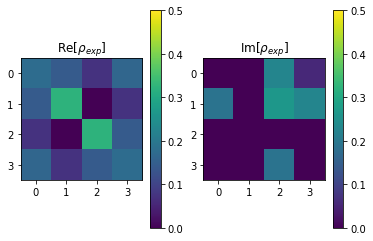

In [149]:
plot_rho(r)

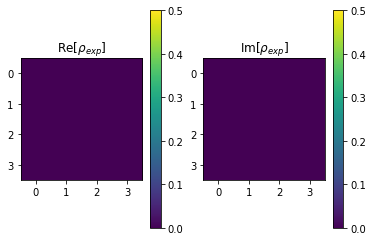

In [150]:
plot_rho(r-rho)

In [151]:
print(np.trace(r))
print(la.eigh(r,eigvals_only=True))
print(la.eigh(rho, eigvals_only=True))

(1+0j)
[-1.03735184e-03  1.21948127e-04  8.87545885e-04  1.00002786e+00]
[-2.60648938e-16 -1.26106675e-17  4.88745101e-04  9.99511255e-01]


In [152]:
# compute entanglement entropy
evals, vecs = la.eig(rho)
s_ent = -np.sum(evals*np.log(evals))
print("Entanglement entropy: ", s_ent)

Entanglement entropy:  (0.004214656751301459+4.811435627042304e-16j)


# 2. Bell's inequalities

A state as simple as the singlet allows us to test a very deep result of quantum mechanics: the violation of Bell's inequalities. Some people even go as far as calling this the most fundamental result of quantum mechanics.

So here we go. Given operators $A_i$ and $B_i$ that live on different hilbert spaces (and may even be spatially separated from each other), construct

$$
\mathcal{E} = A_0B_0 + A_0 B_1 + A_1B_0 - A_1 B_1.
$$

With a bit of algebra we can show that

$$\mathcal{E}^2 = 4\mathbf{I} - [A_0, A_1][B_0, B_1]. \tag{4} \label{E^2} $$

So, classically, it is clear that the measurement of $\mathcal{E}$ is bounded by two. This is called the [CHSH](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.23.880) bound.

For non-commuting operators we have to work harder:
$$
\begin{align*}
\langle \mathcal{E}^2\rangle & \leq ||\mathcal{E}^2|| \\
    & = ||4\mathbf{I} - [A_0,A_1][B_0, B_1]|| \\
    & \leq 4 + ||[A_0, A_1]|| \cdot ||[B_0, B_1]|| \\
    & \leq 4 + 4||A_0|| \cdot || A_1|| \cdot || B_0 || \cdot || B_1|| = 8.
\end{align*}
$$

This leads to *Tsirelson's bound* on the expectation $\langle\mathcal{E}\rangle$:

$$
|\langle\mathcal{E}\rangle|\leq \sqrt{\langle \mathcal{E}^2\rangle} =2\sqrt{2}. \tag{7}\label{tsi}
$$

$$A_0 = -\frac{Z_A + X_A}{\sqrt{2}}, \quad A_1 = \frac{Z_A - X_A}{\sqrt{2}}, \quad B_0 = X_B, \quad B_1 = Z_B .$$

In [60]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device('default.qubit', wires=2)
#dev = qml.device('qiskit.ibmq', wires=2, backend='ibmqx2', shots=1000)

X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])

B0 = X
B1 = Z
A0 = -(Z + X)/np.sqrt(2)
A1 = (Z - X)/np.sqrt(2)

C = np.kron(A0, B0 + B1) + np.kron(A1, B0 - B1)


@qml.qnode(dev)
def circuit():
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])

    return qml.expval(qml.Hermitian(C, wires=[0, 1]))


expval = circuit()
print('<E> = ', expval)

<E> =  2.8284271247461885


# Deutsch–Jozsa algorithm

The [Deutsch–Jozsa algorithm](https://www.isical.ac.in/~rcbose/internship/lectures2016/rt08deutschjozsa.pdf) is a toy algorithm that solves the following task on a quantum computer more more efficiently than a classical computer. Given a function 
$$
f : \{0,1\}^n \rightarrow \{0,1\} 
$$
that is 
1. either constant: $f(x)=0$ or $f(x)=1$
2. or balanced: $\sum_{x=0}^{2^n-1} f(x) = 2^{n-1}$

With a classical deterministic algorithm, the function $f(x)$ needs to be evaluated $2^{n-1}+1$ times in the worst case. We will see that the quantum algorithm only requires a single function query.

In the Deutsch–Jozsa formulation, the function $f$ is implement as the following quantum oracle. It takes $n+1$ input qubits
and returns

$$
\ket{x}\ket{1} \rightarrow \ket{x} \ket{y \oplus f(x)}
$$

Here $\ket{x} = \ket{x_0 x_1 \dots x_{n-1}}$ and $\oplus$ is addition moduloo 2.

# 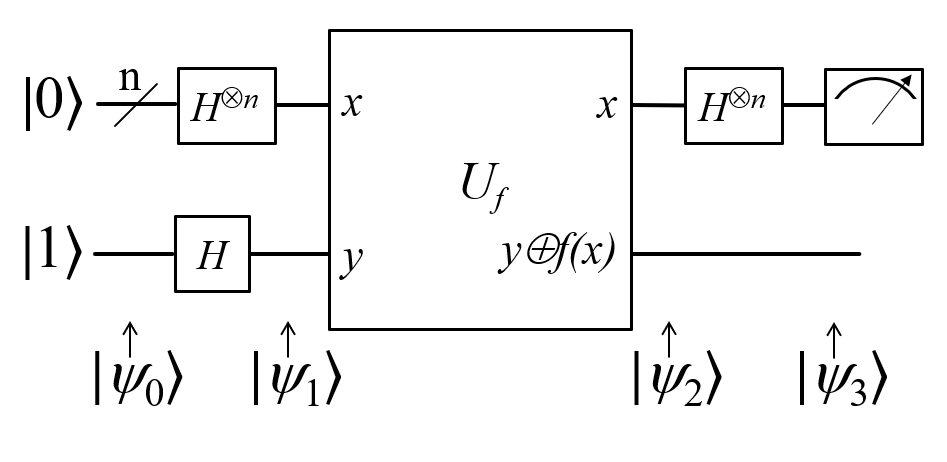
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$
Figure: wikipedia CC BY-SA 4.0




The input state $\ket{\psi_0}$ is transformed by a Hadamrd gates acting on all qubits into (up to some normalization factor)

$$
\ket{\psi_1} = \sum_{x=0}^{2^n-1} \ket{x} (\ket{0}-\ket{1})
$$

We now apply the orace to get

$$
\ket{\psi_2} = \sum_{x=0}^{2^n-1} \ket{x} (\ket{f(x)}-\ket{1 \oplus f(x)})
$$

It is easy to see that

$$
\ket{f(x)}-\ket{1 \oplus f(x)} = (-1)^{f(x)} (\ket{0}-\ket{1})
$$

i.e. each terms simply picks up a phase of $\pi$ depending on the value of $f(x)$. At this point, the last qubit may be ignored and all that remains is

$$
\ket{\psi_2} = \sum_{x=0}^{2^n-1} (-1)^{f(x)} \ket{x} 
$$

Finally, we apply Hadamard gates to all qubits. Remember that $H\ket{0} = \ket{0}+\ket{1}$ and $H\ket{1} = \ket{0}-\ket{1}$. Convince yourself that

$$
H^{\otimes n} \ket{x} = \sum_{y=0}^{2^n-1} (-1)^{x \cdot y} \ket{y}
$$

where $x \cdot y = x_0 y_0 \oplus x_1 y_1 \oplus \dots \oplus x_n y_n$ is the bitwise product. Then we have

$$
\ket{\psi_3} = \sum_{y=0}^{2^n-1} \sum_{x=0}^{2^n-1} (-1)^{f(x)} (-1)^{x\cdot y} \ket{y}
$$

Finally, we perform a measurement in the computational (z-) basis. The probability of getting $\ket{0}$ is (now putting the normalization back in)

$$
\left| \frac{1}{2^n} \sum_{y=0}^{2^n-1} \sum_{x=0}^{2^n-1} (-1)^{f(x)} (-1)^{x\cdot y} \langle 0 | y \rangle \right|^2 
=
\left| \frac{1}{2^n} \sum_{x=0}^{2^n-1} (-1)^{f(x)}\right|^2
$$

which sums to zero if $f(x)$ is balanced or gives 1 if it is constant.
